In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR']= 'platform'


In [13]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from functools import partial
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import blackjax

sns.set(font_scale=2, style='whitegrid')

In [3]:
_raw_data = pd.read_csv('snelson.csv')
x_all, y_all = np.atleast_2d(_raw_data.x.values).T, np.atleast_2d(_raw_data.y.values).T
# x_all = (x_all - np.mean(x_all, axis=0, keepdims=True)) / np.std(x_all, axis=0, keepdims=True)
# y_all = (y_all - np.mean(y_all, axis=0, keepdims=True)) / np.std(y_all, axis=0, keepdims=True)
x_all.shape, y_all.shape

((200, 1), (200, 1))

/tmp/ipykernel_2831419/639316137.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


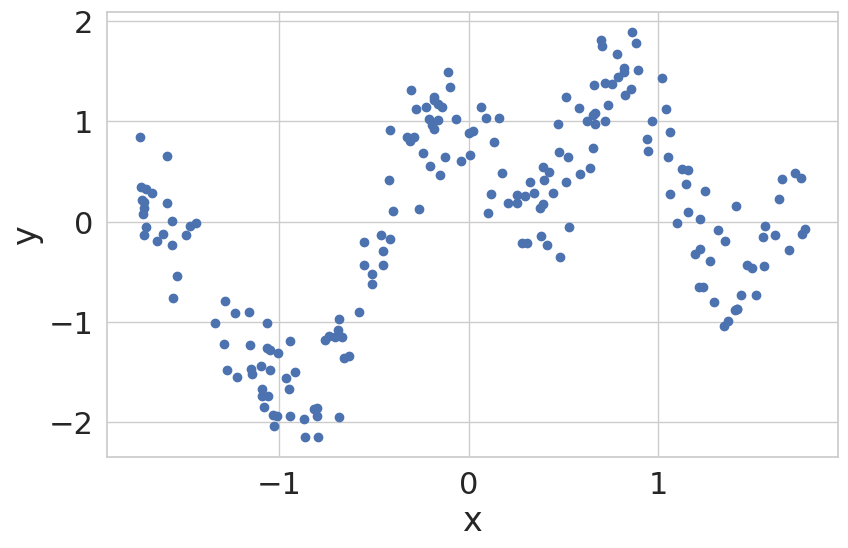

In [4]:
x_test = np.linspace(x_all.min() - 1., x_all.max() + 1., 500)
x_test = np.atleast_2d(x_test).T
x_test.shape

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))

ax.scatter(x_all, y_all)

ax.set(xlabel='x', ylabel='y')

fig.tight_layout()
fig.show()

In [6]:
from flax import linen as nn

class MLP(nn.Module):
    out_size: int
    H: int = 100

    @nn.compact
    def __call__(self, x):
        out = nn.Sequential([
            nn.Dense(features=self.H),
            nn.tanh,
            nn.Dense(features=self.H),
            nn.tanh,
            nn.Dense(features=self.out_size),
        ])(x)
        return out

In [7]:
rng_key = jax.random.PRNGKey(42)

In [ ]:
model = MLP(out_size=1)
rng_key, init_params_key = jax.random.split(rng_key)
init_params = jax.jit(model.init)(init_params_key, jnp.ones((1, 1)))
n_params = sum([len(jnp.ravel(p)) for p in jax.tree_util.tree_flatten(init_params)[0]])

## HMC

In [8]:
import distrax


def logprior_fn(params):
    leaves, _ = jax.tree_util.tree_flatten(params)
    flat_params = jnp.concatenate([jnp.ravel(p) for p in leaves])
    lik = distrax.Normal(0., 1.).log_prob(flat_params)
    return jnp.sum(lik)

def loglikelihood_fn(params, X, Y, model):
    f = model.apply(params, X)
    lik = distrax.Normal(f, 1.).log_prob(Y)
    return jnp.sum(lik)

def logprob_fn(params, X, Y, model):
    return loglikelihood_fn(params, X, Y, model) + logprior_fn(params)

def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

logposterior_fn = partial(logprob_fn, X=x_all, Y=y_all, model=model)

In [9]:
n_warmup = 500
adapt = blackjax.window_adaptation(blackjax.nuts, logposterior_fn, n_warmup)
rng_key, warmup_key = jax.random.split(rng_key)
final_state, kernel, _ = adapt.run(warmup_key, init_params)

(200, 1)

In [ ]:
num_samples = 100
rng_key, inference_key = jax.random.split(rng_key)
states = inference_loop(inference_key, kernel, final_state, num_samples)
samples = states.position

In [ ]:
def get_predictions(model, samples, X):
    vmap = jax.vmap(model.apply, in_axes=(0, None), out_axes=0)
    predictions = vmap(samples, X)
    return predictions.squeeze(-1)

predictions = get_predictions(model, samples, x_test)
predictions.shape

In [10]:
fig, ax = plt.subplots(figsize=(9,6))

y_test = np.mean(predictions, axis=0)
y_test_std = np.std(predictions, axis=0)
ax.plot(x_test[..., 0], y_test, c='red', label='NUTS Mean')
ax.fill_between(x_test[..., 0], y_test - 2 * y_test_std, y_test + 2 * y_test_std, color='red', alpha=.2)

ax.scatter(x_all, y_all, label='Train Data')

ax.set(xlabel='x', ylabel='y', ylim=[-3,3])
ax.legend()

fig.tight_layout()
fig.show()

## SGD

In [ ]:
rng_key = jax.random.PRNGKey(42)

In [ ]:
model = MLP(out_size=1)
rng_key, init_params_key = jax.random.split(rng_key)
init_params = jax.jit(model.init)(init_params_key, jnp.ones((1, 1)))
n_params = sum([len(jnp.ravel(p)) for p in jax.tree_util.tree_flatten(init_params)[0]])

In [15]:
from flax.training import train_state
import optax

lr = 3e-2
momentum = .9
tx = optax.sgd(lr, momentum=momentum)
ts = train_state.TrainState.create(apply_fn=model.apply, params=init_params, tx=tx)

100%|██████████| 100/100 [01:21<00:00,  1.22it/s]


(200, 1, 100)

In [ ]:
def l2_loss_fn(params, X, Y, model, lmbda=1e-2):
    y_pred = model.apply(params, X)
    loss = jnp.mean((Y - y_pred)**2)
    
    leaves, _ = jax.tree_util.tree_flatten(params)
    reg = jnp.sum(jnp.array([jnp.sum(jnp.ravel(p)**2) for p in leaves]))
    return loss + .5 * lmbda * reg

loss_fn = partial(l2_loss_fn, X=x_all, Y=y_all, model=model, lmbda=1e-3)
grad_fn = jax.value_and_grad(loss_fn)

In [ ]:
## TODO: lax scan?
for e in tqdm(range(3000)):
    _, grads = grad_fn(ts.params)
    ts = ts.apply_gradients(grads=grads)

    if (e + 1) % 500 == 0:
        y_pred = model.apply(ts.params, x_all)
        loss = jnp.mean((y_all - y_pred)**2)
        print(f'Loss: {loss}')

/tmp/ipykernel_2831419/1677605177.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


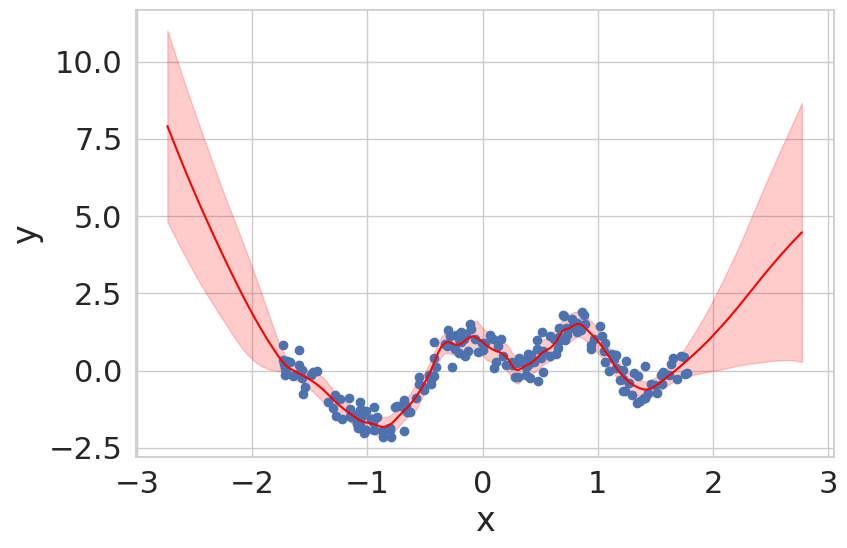

In [16]:
fig, ax = plt.subplots(figsize=(9,6))

y_test = model.apply(ts.params, x_test)[..., 0]
ax.plot(x_test[..., 0], y_test, c='black', label='GD MAP')

y_test = np.mean(predictions, axis=0)
y_test_std = np.std(predictions, axis=0)
ax.plot(x_test[..., 0], y_test, c='red', label='NUTS Mean')
ax.fill_between(x_test[..., 0], y_test - 2 * y_test_std, y_test + 2 * y_test_std, color='red', alpha=.2)

ax.scatter(x_all, y_all, label='Train Data', alpha=.5)

ax.set(xlabel='x', ylabel='y', ylim=[-3,3])
ax.legend()

fig.tight_layout()
fig.show()